## Initial Setup

In [1]:
import os 
os.environ['PROJ_LIB'] = '/umbc/xfs1/jianwu/common/anaconda3/share/proj'
#export 'PROJ_LIB' = /umbc/xfs1/cybertrn/common/Softwares/anaconda3/share/proj

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as CS
import os,datetime,sys,fnmatch
from mpl_toolkits import basemap
from mpl_toolkits.basemap import Basemap,maskoceans 
from netCDF4 import Dataset
from pyhdf.SD import SD, SDC
import os
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd
import xarray as xr

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Base Function for Plotting 

In [2]:
# simple plotting function
def plot_2D_global(lons,lats,data_2D,
                   data_name=None,
                   levels=20,
                   plot_type='normal',
                   vmin=0, vmax=0,
                   cmap='rainbow',
                   label=''
                   ):
    
    mapproj = Basemap(projection='cyl',
                llcrnrlat=-90, #lats.min(),
                llcrnrlon=lons.min(),
                urcrnrlat= 90, #lats.max(),
                urcrnrlon= lons.max())
    
    lonall, latall = mapproj.makegrid(lons.size, lats.size)
    lonproj, latproj = mapproj(lonall, latall)
    
    latlines = np.arange(latall.min(),latall.max()+1,15)
    lonlines = np.arange(lonall.min(),lonall.max()+1,45)
    
    if plot_type =='normal':
        ctr = mapproj.contourf(lonproj, latproj,data_2D,
                           vmin = vmin,
                           vmax = vmax,
                           levels = levels,
                           cmap   = cmap)
        
    elif plot_type == 'difference':
        ctr = mapproj.contourf(lonproj, latproj,data_2D,
                           vmin = vmin,
                           vmax = vmax,
                           levels = levels,
                           cmap   = cmap,
                           cbar_kwargs={"ticks": levels})
        plt.clim(vmin,vmax)
        
    
    
    plt.title(data_name)
    
    mapproj.drawcoastlines()
    mapproj.drawparallels(latlines, labels=[1,0,0,0])
    mapproj.drawmeridians(lonlines, labels=[0,0,0,1])
    
    mapproj.colorbar(ctr,"bottom", size="5%",pad = '20%', label=label)
    
    figname = data_name+'.png'
            
    #plt.savefig('Results/'+figname,dpi=200)
    
    #plt.show()

## Base Function for Reading Data

In [3]:
def read_data(data_type,var_name):
    data_dir = '//umbc/xfs1/zzbatmos/common/Data/'
    new_data_dir = '/umbc/xfs1/cybertrn/cybertraining2020/team3/research/cmip6/src/'

    #Reading from Observations 
    
    if data_type == 'ceres':
        prefix = 'CERES/CERES_EBAF-TOA_Edition4.0_200003-201701.nc'
        ncfile = data_dir + prefix
        
        # define the class for reading 2D (lat-lon) ceres data
        class ceres_data_2D(object):
            def __init__(self,fn,var):   
                dataset = Dataset(fn)
                self.name = var
                self.lons = dataset.variables['lon'][:]
                self.lats = dataset.variables['lat'][:]
                self.time = dataset.variables['time'][75:178]
                self.data = dataset.variables[var][75:178:,:,:]
                
        data = ceres_data_2D(ncfile,var_name)
        
    elif data_type == 'cal-goccp':
        prefix = 'CALIPSO/CALIPSO-GOCCP/climato/'
        suffix = 'MapLowMidHigh330m_200606-201803_avg_CFMIP2_sat_3.1.2.nc'
        ncfile = data_dir + prefix + suffix
        
        # define the class for reading 2D (lat-lon) ceres data
        class cal_data_2D(object):
            def __init__(self,fn,var):   
                dataset = Dataset(fn)
                self.name = var
                self.lons = dataset.variables['longitude'][:]
                self.lats = dataset.variables['latitude'][:]
                self.time = dataset.variables['time'][:104]  #2006-05-01 - 2014-12-16
                self.data = dataset.variables[var][:104,:,:]
                
        data = cal_data_2D(ncfile,var_name)
    
    #Reading from CMIP6 Models
    
    if data_type == 'cesm':
        prefix = 'cesm-data/'
        if var_name in ('cllcalipso','clmcalipso','clhcalipso','cltcalipso'):
            suffix = '_CFmon_CESM2_amip_r1i1p1f1_gn_195001-201412.nc'
        elif var_name in ('rsdt','rsut','rsutcs'):
            suffix = '_Amon_CESM2_amip_r1i1p1f1_gn_195001-201412.nc'
        
        ncfile   =  new_data_dir + prefix + var_name + suffix
        
        # define the class for reading 2D (lat-lon) cesm data
        class cesm_data_2D(object):
            def __init__(self,fn,var):   
                dataset = Dataset(fn)
                self.name = var
                self.lons = dataset.variables['lon'][:]
                self.lats = dataset.variables['lat'][:]
                self.time = dataset.variables['time'][676:] #2006-05-01 - 2014-12-01
                self.data = dataset.variables[var][676:,:,:]
                
        data = cesm_data_2D(ncfile,var_name)     

    elif data_type == 'giss':
        prefix = 'giss-data/'
        if var_name in ('cllcalipso','clmcalipso','clhcalipso','cltcalipso'):
            suffix = '_CFmon_GISS-E2-1-G_amip_r1i1p1f1_gn_'
            ncfile = new_data_dir + prefix + var_name + suffix

            # define the class for reading 2D (lat-lon) giss data
            class giss_data_2D(object):
                def __init__(self,fn,var):
                    dataset = xr.open_mfdataset(fn+'*.nc')
                    self.name = var
                    self.lons = xr.DataArray.to_masked_array(dataset.variables['lon'][:])
                    self.lats = xr.DataArray.to_masked_array(dataset.variables['lat'][:])
                    self.time = xr.DataArray.to_masked_array(dataset.variables['time'][88:])  #2006-05-01 - 2014-12-01
                    self.data = xr.DataArray.to_masked_array(dataset.variables[var][88:,:,:])
        
            data = giss_data_2D(ncfile,var_name)
            
        elif var_name in ('rsdt','rsut','rsutcs'):
            suffix = '_Amon_GISS-E2-1-G_amip_r1i1p1f1_gn_200101-201412.nc'
            ncfile = new_data_dir + prefix + var_name + suffix

            # define the class for reading 2D (lat-lon) giss radiative data
            class giss_data_2D(object):
                def __init__(self,fn,var):   
                    dataset = Dataset(fn)
                    self.name = var
                    self.lons = dataset.variables['lon'][:]
                    self.lats = dataset.variables['lat'][:]
                    self.time = dataset.variables['time'][60:] #2006-05-01 - 2014-12-01
                    self.data = dataset.variables[var][60:,:,:]
                
        data = giss_data_2D(ncfile,var_name)
        
    elif data_type == 'noaa':
        prefix = 'noaa-data/'
        if var_name in ('cllcalipso','clmcalipso','clhcalipso','cltcalipso'):
            suffix = '_CFmon_GFDL-CM4_amip_r1i1p1f1_gr1_'
        elif var_name in ('rsdt','rsut','rsutcs'):
            suffix = '_Amon_GFDL-CM4_amip_r1i1p1f1_gr1_' 

        ncfile   =  new_data_dir + prefix + var_name + suffix
            
        # define the class for reading 2D (lat-lon) giss radiative data
        class noaa_data_2D(object):
            def __init__(self,fn,var):   
                dataset = xr.open_mfdataset(fn+'*.nc')
                self.name = var
                self.lons = xr.DataArray.to_masked_array(dataset.variables['lon'][:])
                self.lats = xr.DataArray.to_masked_array(dataset.variables['lat'][:])
                self.time = xr.DataArray.to_masked_array(dataset.variables['time'][40:])  #2006-05-01 - 2014-12-01
                self.data = xr.DataArray.to_masked_array(dataset.variables[var][40:,:,:])
                
        data = noaa_data_2D(ncfile,var_name)
        
    return data

## Radiation Data

### CERES Shortwave Flux

In [4]:
#CERES-TOA SW
solar_mon_data = read_data(data_type='ceres', var_name = 'solar_mon') # solar_mon

toa_sw_data = read_data(data_type='ceres',var_name='toa_sw_all_mon') # TOA Shortwave Flux - All-Sky
net_sw_toa = solar_mon_data.data.mean(axis=0) - toa_sw_data.data.mean(axis=0)

toa_sw_clr_data = read_data(data_type='ceres',var_name='toa_sw_clr_mon') # TOA Shortwave Flux - Clear-Sky
net_sw_toa_clr = solar_mon_data.data.mean(axis=0) - toa_sw_clr_data.data.mean(axis=0)

print (np.shape(solar_mon_data.data))

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type


(103, 180, 360)


### GISS Shortwave Flux

In [5]:
GRSDT_data = read_data(data_type='giss',var_name='rsdt') # TOA Incoming Shortwave Flux 
GRSDT_mean = GRSDT_data.data.mean(axis=0)

GRSUT_data = read_data(data_type='giss',var_name='rsut') # TOA Outgoing Shortwave Flux 
GRSUT_mean = GRSUT_data.data.mean(axis=0)

GRSUTCS_data = read_data(data_type='giss',var_name='rsutcs') # TOA Outgoing Clear-Sky Shortwave Flux 
GRSUTCS_mean = GRSUTCS_data.data.mean(axis=0)

#GISS-TOA SW data

giss_net_sw_data = GRSDT_data.data.mean(axis=0) - GRSUT_data.data.mean(axis=0)
print (np.shape(giss_net_sw_data.data))

# Clear Sky

giss_net_rscs_data = GRSDT_data.data.mean(axis=0) - GRSUTCS_data.data.mean(axis=0)
print (np.shape(giss_net_rscs_data.data))

(90, 144)
(90, 144)


### NOAA Shortwave Flux

In [6]:
NRSDT_data = read_data(data_type='noaa',var_name='rsdt') # TOA Incoming Shortwave Flux 
NRSDT_mean = NRSDT_data.data.mean(axis=0)

NRSUT_data = read_data(data_type='noaa',var_name='rsut') # TOA Outgoing Shortwave Flux 
NRSUT_mean = NRSUT_data.data.mean(axis=0)

NRSUTCS_data = read_data(data_type='noaa',var_name='rsutcs') # TOA Outgoing Clear-Sky Shortwave Flux 
NRSUTCS_mean = NRSUTCS_data.data.mean(axis=0)

#NOAA-TOA SW data

noaa_net_sw_data = NRSDT_data.data.mean(axis=0) - NRSUT_data.data.mean(axis=0)
print (np.shape(noaa_net_sw_data.data))

# Clear Sky

noaa_net_rscs_data = NRSDT_data.data.mean(axis=0) - NRSUTCS_data.data.mean(axis=0)
print (np.shape(noaa_net_rscs_data.data))

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipyke

(180, 288)
(180, 288)


### CESM Shortwave Flux

In [7]:
CRSDT_data = read_data(data_type='cesm',var_name='rsdt') # TOA Incoming Shortwave Flux 
CRSDT_mean = CRSDT_data.data.mean(axis=0)

CRSUT_data = read_data(data_type='cesm',var_name='rsut') # TOA Outgoing Shortwave Flux 
CRSUT_mean = CRSUT_data.data.mean(axis=0)

CRSUTCS_data = read_data(data_type='cesm',var_name='rsutcs') # TOA Outgoing Clear-Sky Shortwave Flux
CRSUTCS_mean = CRSUTCS_data.data.mean(axis=0)

#NOAA-TOA SW data

cesm_net_sw_data = CRSDT_data.data.mean(axis=0) - CRSUT_data.data.mean(axis=0)
print (np.shape(cesm_net_sw_data.data))

# Clear Sky

cesm_net_rscs_data = CRSDT_data.data.mean(axis=0) - CRSUTCS_data.data.mean(axis=0)
print (np.shape(cesm_net_rscs_data.data))

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


(192, 288)
(192, 288)


### Plotting Shortwave Flux Data - Clear Sky

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


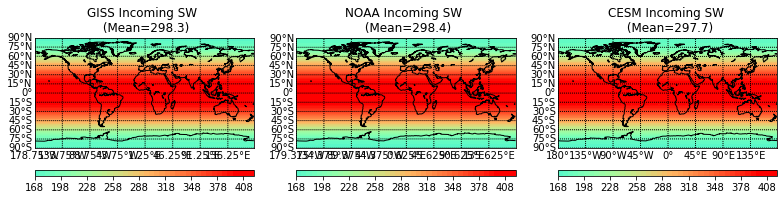

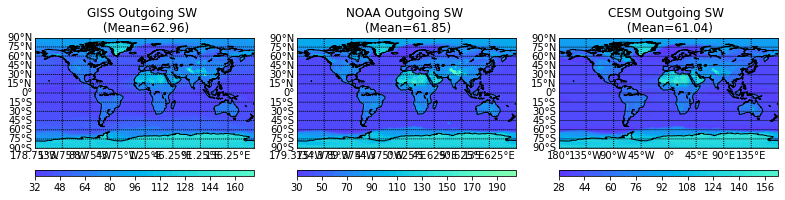

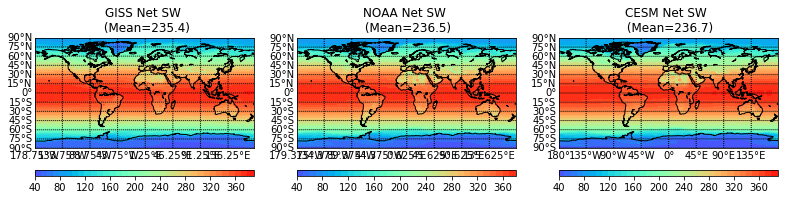

In [8]:
# Incoming SW (TOA)

plt.figure(figsize=(11,11.5))
plt.subplot(131)
plot_2D_global(GRSDT_data.lons+180,GRSDT_data.lats,np.roll(GRSDT_mean,72,axis=1), data_name = 'GISS Incoming SW \n (Mean=%.4g)' %np.mean(np.roll(GRSDT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(132)
plot_2D_global(NRSDT_data.lons+180,NRSDT_data.lats,np.roll(NRSDT_mean,144,axis=1), data_name = 'NOAA Incoming SW \n (Mean=%.4g)' %np.mean(np.roll(NRSDT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(133)
plot_2D_global(CRSDT_data.lons+180,CRSDT_data.lats,np.roll(CRSDT_mean,144,axis=1), data_name = 'CESM Incoming SW \n (Mean=%.4g)' %np.mean(np.roll(CRSDT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')

plt.tight_layout()
plt.savefig('Results/4IncomingSW_clearsky')
plt.show()

# Outging SW (TOA)

plt.figure(figsize=(11,11.5))
plt.subplot(131)
plot_2D_global(GRSUTCS_data.lons+180,GRSUTCS_data.lats,np.roll(GRSUTCS_mean,72,axis=1), data_name = 'GISS Outgoing SW \n (Mean=%.4g)' %np.mean(np.roll(GRSUTCS_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(132)
plot_2D_global(NRSUTCS_data.lons+180,NRSUTCS_data.lats,np.roll(NRSUTCS_mean,144,axis=1), data_name = 'NOAA Outgoing SW \n (Mean=%.4g)' %np.mean(np.roll(NRSUTCS_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(133)
plot_2D_global(CRSUTCS_data.lons+180,CRSUTCS_data.lats,np.roll(CRSUTCS_mean,144,axis=1), data_name = 'CESM Outgoing SW \n (Mean=%.4g)' %np.mean(np.roll(CRSUTCS_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')

plt.tight_layout()
plt.savefig('Results/5OutgoingSW_clearsky')
plt.show()



# TODO: Net SW (TOA)

plt.figure(figsize=(11,11.5))
plt.subplot(131)
plot_2D_global(GRSDT_data.lons+180,GRSDT_data.lats,np.roll(giss_net_rscs_data,72,axis=1), data_name = 'GISS Net SW \n (Mean=%.4g)' %np.mean(np.roll(giss_net_rscs_data,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(132)
plot_2D_global(NRSDT_data.lons+180,NRSDT_data.lats,np.roll(noaa_net_rscs_data,144,axis=1), data_name = 'NOAA Net SW \n (Mean=%.4g)' %np.mean(np.roll(noaa_net_rscs_data,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(133)
plot_2D_global(CRSDT_data.lons+180,CRSDT_data.lats,np.roll(cesm_net_rscs_data,144,axis=1), data_name = 'CESM Net SW \n (Mean=%.4g)' %np.mean(np.roll(cesm_net_rscs_data,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')



plt.tight_layout()
plt.savefig('Results/6NetSW_clearsky')
plt.show()

### Plotting Shortwave Flux Data - All Sky

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


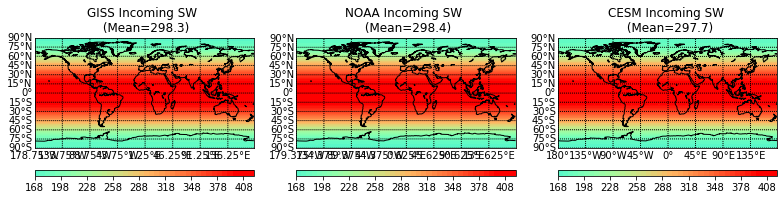

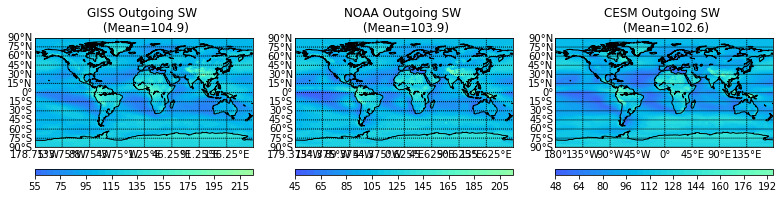

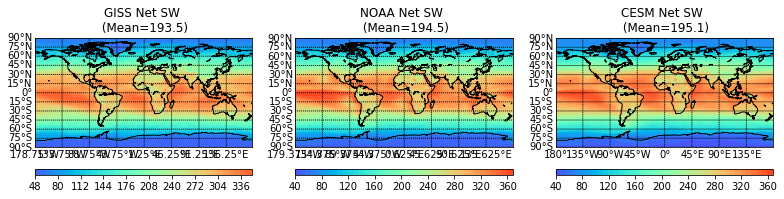

In [9]:
# Incoming SW (TOA)
#TODO: Fix means value by np.roll

plt.figure(figsize=(11,11.5))
plt.subplot(131)
plot_2D_global(GRSDT_data.lons+180,GRSDT_data.lats,np.roll(GRSDT_mean,72,axis=1), data_name = 'GISS Incoming SW \n (Mean=%.4g)' %np.mean(np.roll(GRSDT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(132)
plot_2D_global(NRSDT_data.lons+180,NRSDT_data.lats,np.roll(NRSDT_mean,144,axis=1), data_name = 'NOAA Incoming SW \n (Mean=%.4g)' %np.mean(np.roll(NRSDT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(133)
plot_2D_global(CRSDT_data.lons+180,CRSDT_data.lats,np.roll(CRSDT_mean,144,axis=1), data_name = 'CESM Incoming SW \n (Mean=%.4g)' %np.mean(np.roll(CRSDT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')

plt.tight_layout()
plt.savefig('Results/1IncomingSW_allsky')
plt.show()

# Outging SW (TOA)

plt.figure(figsize=(11,11.5))
plt.subplot(131)
plot_2D_global(GRSUT_data.lons+180,GRSUT_data.lats,np.roll(GRSUT_mean,72,axis=1), data_name = 'GISS Outgoing SW \n (Mean=%.4g)' %np.mean(np.roll(GRSUT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(132)
plot_2D_global(NRSUT_data.lons+180,NRSUT_data.lats,np.roll(NRSUT_mean,144,axis=1), data_name = 'NOAA Outgoing SW \n (Mean=%.4g)' %np.mean(np.roll(NRSUT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(133)
plot_2D_global(CRSUT_data.lons+180,CRSUT_data.lats,np.roll(CRSUT_mean,144,axis=1), data_name = 'CESM Outgoing SW \n (Mean=%.4g)' %np.mean(np.roll(CRSUT_mean,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')

plt.tight_layout()
plt.savefig('Results/2OutgoingSW_allsky')
plt.show()


# Net SW (TOA)

plt.figure(figsize=(11,11.5))
plt.subplot(131)
plot_2D_global(GRSDT_data.lons+180,GRSDT_data.lats,np.roll(giss_net_sw_data,72,axis=1), data_name = 'GISS Net SW \n (Mean=%.4g)' %np.mean(np.roll(giss_net_sw_data,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(132)
plot_2D_global(NRSDT_data.lons+180,NRSDT_data.lats,np.roll(noaa_net_sw_data,144,axis=1), data_name = 'NOAA Net SW \n (Mean=%.4g)' %np.mean(np.roll(noaa_net_sw_data,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')
plt.subplot(133)
plot_2D_global(CRSDT_data.lons+180,CRSDT_data.lats,np.roll(cesm_net_sw_data,144,axis=1), data_name = 'CESM Net SW \n (Mean=%.4g)' %np.mean(np.roll(cesm_net_sw_data,72,axis=1)), levels=40, plot_type='normal', vmin=0, vmax=400, cmap='rainbow')

#TODO - Sahara: Print means with all plots

plt.tight_layout()
plt.savefig('Results/3NetSW_allsky')
plt.show()

### Bias Plots

cesm_trop_netsw= 305.24484
giss_trop_netsw= 299.6729
gfdl_trop_netsw= 302.1233203405984
obs_trop_netsw= 303.725


/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'


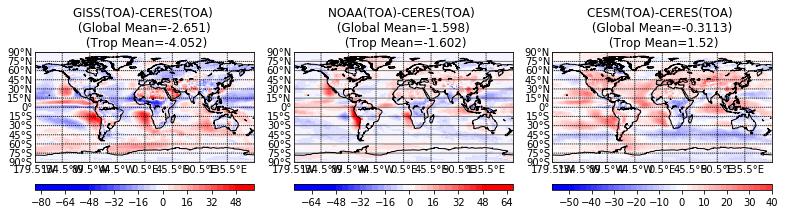

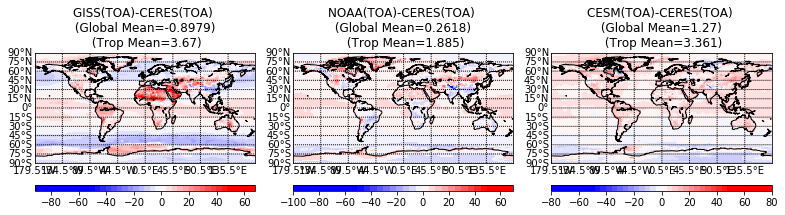

cesm_trop_netcre= -44.862705
giss_trop_netcre= -50.74395
gfdl_trop_netcre= -46.508851029769446
obs_trop_netcre= -43.021683


In [10]:
# SW GISS, CESM, NOAA and CERES bias plots for All Sky

plt.figure(figsize=(11,11.5))
lonout, latout = np.meshgrid(toa_sw_data.lons, toa_sw_data.lats)

GISS_TOA_interp = basemap.interp(giss_net_sw_data,GRSDT_data.lons, GRSDT_data.lats, lonout, latout)
CESM_TOA_interp = basemap.interp(cesm_net_sw_data,CRSDT_data.lons, CRSDT_data.lats, lonout, latout)
NOAA_TOA_interp = basemap.interp(noaa_net_sw_data,NRSDT_data.lons, NRSDT_data.lats, lonout, latout)

print ('cesm_trop_netsw=', np.nanmean(CESM_TOA_interp[60:121,0:361]))
print ('giss_trop_netsw=', np.nanmean(GISS_TOA_interp[60:121,0:361]))
print ('gfdl_trop_netsw=', np.nanmean(NOAA_TOA_interp[60:121,0:361]))
print ('obs_trop_netsw=', np.nanmean(net_sw_toa[60:121,0:361]))

plt.subplot(131)
plot_2D_global(toa_sw_data.lons+180,toa_sw_data.lats,np.roll((GISS_TOA_interp-net_sw_toa),180), data_name = 'GISS(TOA)-CERES(TOA) \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GISS_TOA_interp-net_sw_toa,180,axis=1)),np.mean(np.roll(GISS_TOA_interp-net_sw_toa,180,axis=1)[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='bwr')
plt.subplot(133)
plot_2D_global(toa_sw_data.lons+180,toa_sw_data.lats,np.roll((CESM_TOA_interp-net_sw_toa),180), data_name = 'CESM(TOA)-CERES(TOA) \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CESM_TOA_interp-net_sw_toa,180,axis=1)),np.mean(np.roll(CESM_TOA_interp-net_sw_toa,180,axis=1)[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='bwr')
plt.subplot(132)
plot_2D_global(toa_sw_data.lons+180,toa_sw_data.lats,np.roll((NOAA_TOA_interp-net_sw_toa),180), data_name = 'NOAA(TOA)-CERES(TOA) \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NOAA_TOA_interp-net_sw_toa,180,axis=1)),np.mean(np.roll(NOAA_TOA_interp-net_sw_toa,180,axis=1)[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='bwr')

plt.tight_layout()
plt.savefig('Results/7BiasSW_allsky')
plt.show()

# SW GISS, CESM, NOAA and CERES bias plots for Clear Sky

plt.figure(figsize=(11,11.5))
lonout, latout = np.meshgrid(toa_sw_data.lons, toa_sw_data.lats)

GISS_TOA_interp_cs = basemap.interp(giss_net_rscs_data,GRSDT_data.lons, GRSDT_data.lats, lonout, latout)
CESM_TOA_interp_cs = basemap.interp(cesm_net_rscs_data,CRSDT_data.lons, CRSDT_data.lats, lonout, latout)
NOAA_TOA_interp_cs = basemap.interp(noaa_net_rscs_data,NRSDT_data.lons, NRSDT_data.lats, lonout, latout)

plt.subplot(131)
plot_2D_global(toa_sw_clr_data.lons+180,toa_sw_clr_data.lats,np.roll((GISS_TOA_interp_cs-net_sw_toa_clr),180), data_name = 'GISS(TOA)-CERES(TOA) \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GISS_TOA_interp_cs-net_sw_toa_clr,180,axis=1)),np.mean(np.roll(GISS_TOA_interp_cs-net_sw_toa_clr,180,axis=1)[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='bwr')
plt.subplot(133)
plot_2D_global(toa_sw_clr_data.lons+180,toa_sw_clr_data.lats,np.roll((CESM_TOA_interp_cs-net_sw_toa_clr),180), data_name = 'CESM(TOA)-CERES(TOA) \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CESM_TOA_interp_cs-net_sw_toa_clr,180,axis=1)),np.mean(np.roll(CESM_TOA_interp_cs-net_sw_toa_clr,180,axis=1)[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='bwr')
plt.subplot(132)
plot_2D_global(toa_sw_clr_data.lons+180,toa_sw_clr_data.lats,np.roll((NOAA_TOA_interp_cs-net_sw_toa_clr),180), data_name = 'NOAA(TOA)-CERES(TOA) \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NOAA_TOA_interp_cs-net_sw_toa_clr,180,axis=1)),np.mean(np.roll(NOAA_TOA_interp_cs-net_sw_toa_clr,180,axis=1)[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='bwr')


#plt.suptitle('Clear Sky Net Solar Flux', y=1)
plt.tight_layout()
plt.savefig('Results/8BiasSW_clearsky')
plt.show()

#Achala

print ('cesm_trop_netcre=', np.nanmean((CESM_TOA_interp-CESM_TOA_interp_cs)[60:121,0:361]))
print ('giss_trop_netcre=', np.nanmean((GISS_TOA_interp-GISS_TOA_interp_cs)[60:121,0:361]))
print ('gfdl_trop_netcre=', np.nanmean((NOAA_TOA_interp-NOAA_TOA_interp_cs)[60:121,0:361]))
print ('obs_trop_netcre=', np.nanmean((net_sw_toa-net_sw_toa_clr)[60:121,0:361]))

## Reading Cloud Fraction Data

### GISS CALIPSO Data

In [11]:
# CALIPSO Percentage low Level Cloud
GCLLCALIPSO_data = read_data(data_type='giss',var_name='cllcalipso')
GCLLCALIPSO_mean = GCLLCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage mid Level Cloud
GCLMCALIPSO_data = read_data(data_type='giss',var_name='clmcalipso') 
GCLMCALIPSO_mean = GCLMCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage High Level Cloud
GCLHCALIPSO_data = read_data(data_type='giss',var_name='clhcalipso') 
GCLHCALIPSO_mean = GCLHCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage total Level Cloud
GCLTCALIPSO_data = read_data(data_type='giss',var_name='cltcalipso') 
GCLTCALIPSO_mean = GCLTCALIPSO_data.data.mean(axis=0)

#print(type(GCLTCALIPSO_data.data))
#print(type(GCLTCALIPSO_data.time))
#print(GCLTCALIPSO_mean)
print (np.shape(GCLTCALIPSO_data.data))

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipyker

(104, 90, 144)


/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


### NOAA CALIPSO Data

In [12]:
# CALIPSO Percentage low Level Cloud
NCLLCALIPSO_data = read_data(data_type='noaa',var_name='cllcalipso') 
NCLLCALIPSO_mean = NCLLCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage mid Level Cloud
NCLMCALIPSO_data = read_data(data_type='noaa',var_name='clmcalipso') 
NCLMCALIPSO_mean = NCLMCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage High Level Cloud
NCLHCALIPSO_data = read_data(data_type='noaa',var_name='clhcalipso') 
NCLHCALIPSO_mean = NCLHCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage total Level Cloud
NCLTCALIPSO_data = read_data(data_type='noaa',var_name='cltcalipso') 
NCLTCALIPSO_mean = NCLTCALIPSO_data.data.mean(axis=0)

print (np.shape(NCLHCALIPSO_data.data))

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipyke

(104, 180, 288)


### CESM CALIPSO Data

In [13]:
# CALIPSO Percentage low Level Cloud
CCLLCALIPSO_data = read_data(data_type='cesm',var_name='cllcalipso') 
CCLLCALIPSO_mean = CCLLCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage mid Level Cloud
CCLMCALIPSO_data = read_data(data_type='cesm',var_name='clmcalipso') 
CCLMCALIPSO_mean = CCLMCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage High Level Cloud
CCLHCALIPSO_data = read_data(data_type='cesm',var_name='clhcalipso') 
CCLHCALIPSO_mean = CCLHCALIPSO_data.data.mean(axis=0)

# CALIPSO Percentage total Level Cloud
CCLTCALIPSO_data = read_data(data_type='cesm',var_name='cltcalipso') 
CCLTCALIPSO_mean = CCLTCALIPSO_data.data.mean(axis=0)

print (np.shape(CCLHCALIPSO_data.data))

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


(104, 192, 288)


### CALIPSO-GOCCP Data

In [14]:
# CALIPSO Percentage low Level Cloud
ocllcalipso_data = read_data(data_type='cal-goccp',var_name='cllcalipso') 
ocllcalipso_mean = ocllcalipso_data.data.mean(axis=0)

# CALIPSO Percentage mid Level Cloud
oclmcalipso_data = read_data(data_type='cal-goccp',var_name='clmcalipso') 
oclmcalipso_mean = oclmcalipso_data.data.mean(axis=0)

# CALIPSO Percentage High Level Cloud
oclhcalipso_data = read_data(data_type='cal-goccp',var_name='clhcalipso') 
oclhcalipso_mean = oclhcalipso_data.data.mean(axis=0)

# CALIPSO Percentage total Level Cloud
ocltcalipso_data = read_data(data_type='cal-goccp',var_name='cltcalipso') 
ocltcalipso_mean = ocltcalipso_data.data.mean(axis=0)

print (np.shape(ocltcalipso_data.data))

(104, 90, 180)


### Interpolation into 360x180

In [15]:
#Interpolate all models and observation into 180x360 grid

lons = range(0,360)
lons = np.array(lons)
lats = range(-90,90)
lats = np.array(lats)

lonout, latout = np.meshgrid(lons,lats)


# Low CF

GCLLCALIPSO_interp = basemap.interp(GCLLCALIPSO_mean,GCLLCALIPSO_data.lons+180, GCLLCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
NCLLCALIPSO_interp = basemap.interp(NCLLCALIPSO_mean,NCLLCALIPSO_data.lons+180, NCLLCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
CCLLCALIPSO_interp = basemap.interp(CCLLCALIPSO_mean,CCLLCALIPSO_data.lons+180, CCLLCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
ocllcalipso_interp = basemap.interp(ocllcalipso_mean*100, ocllcalipso_data.lons+180, ocllcalipso_data.lats, lonout, latout, checkbounds=False, masked=False, order=1)

# Mid CF

GCLMCALIPSO_interp = basemap.interp(GCLMCALIPSO_mean,GCLMCALIPSO_data.lons+180, GCLMCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
NCLMCALIPSO_interp = basemap.interp(NCLMCALIPSO_mean,NCLMCALIPSO_data.lons+180, NCLMCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
CCLMCALIPSO_interp = basemap.interp(CCLMCALIPSO_mean,CCLMCALIPSO_data.lons+180, CCLMCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
oclmcalipso_interp = basemap.interp(oclmcalipso_mean*100, oclmcalipso_data.lons+180, oclmcalipso_data.lats, lonout, latout, checkbounds=False, masked=False, order=1)

# High CF

GCLHCALIPSO_interp = basemap.interp(GCLHCALIPSO_mean,GCLHCALIPSO_data.lons+180, GCLHCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
NCLHCALIPSO_interp = basemap.interp(NCLHCALIPSO_mean,NCLHCALIPSO_data.lons+180, NCLHCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
CCLHCALIPSO_interp = basemap.interp(CCLHCALIPSO_mean,CCLHCALIPSO_data.lons+180, CCLHCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
oclhcalipso_interp = basemap.interp(oclhcalipso_mean*100, oclhcalipso_data.lons+180, oclhcalipso_data.lats, lonout, latout, checkbounds=False, masked=False, order=1)

# Total CF

GCLTCALIPSO_interp = basemap.interp(GCLTCALIPSO_mean,GCLTCALIPSO_data.lons+180, GCLTCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
NCLTCALIPSO_interp = basemap.interp(NCLTCALIPSO_mean,NCLTCALIPSO_data.lons+180, NCLTCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
CCLTCALIPSO_interp = basemap.interp(CCLTCALIPSO_mean,CCLTCALIPSO_data.lons+180, CCLTCALIPSO_data.lats, lonout+180, latout,checkbounds=False, masked=False, order=1)
ocltcalipso_interp = basemap.interp(ocltcalipso_mean*100, ocltcalipso_data.lons+180, ocltcalipso_data.lats, lonout, latout, checkbounds=False, masked=False, order=1)


### Plotting Cloud Fraction Data

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


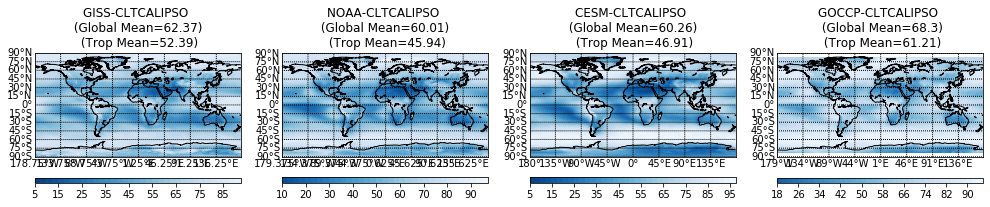

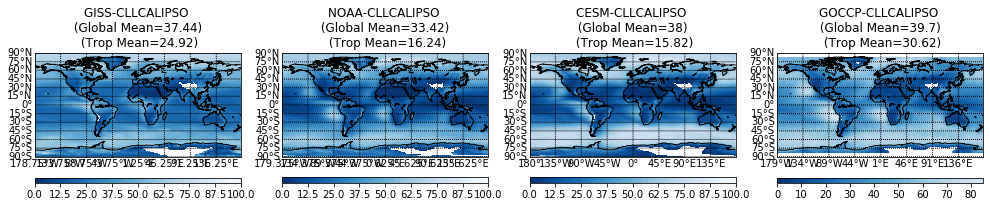

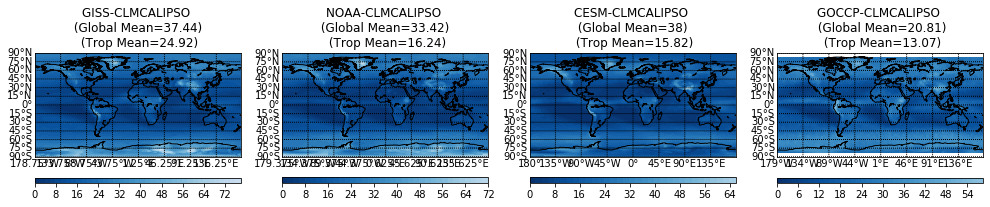

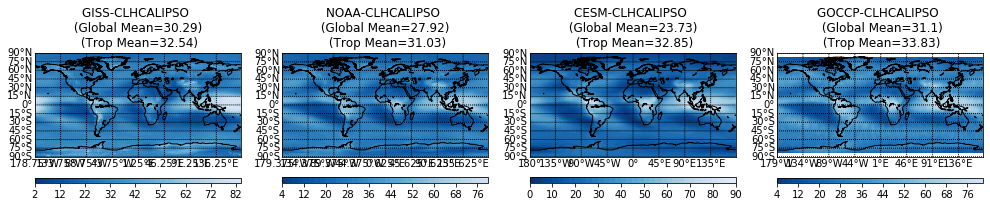

In [16]:
# Plots for all three models

#CLTCALIPSO
plt.figure(figsize=(17,13))
plt.subplot(141)
plot_2D_global(GCLTCALIPSO_data.lons+180,GCLTCALIPSO_data.lats,np.roll(GCLTCALIPSO_mean,72,axis=1), data_name = 'GISS-CLTCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GCLTCALIPSO_mean,72,axis=1)), np.mean(np.roll(GCLTCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(142)
plot_2D_global(NCLTCALIPSO_data.lons+180,NCLTCALIPSO_data.lats,np.roll(NCLTCALIPSO_mean,144,axis=1), data_name = 'NOAA-CLTCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NCLTCALIPSO_mean,144,axis=1)), np.mean(np.roll(NCLTCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(143)
plot_2D_global(CCLTCALIPSO_data.lons+180,CCLTCALIPSO_data.lats,np.roll(CCLTCALIPSO_mean,144,axis=1), data_name = 'CESM-CLTCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CCLTCALIPSO_mean,144,axis=1)), np.mean(np.roll(CCLTCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(144)
plot_2D_global(ocltcalipso_data.lons,ocltcalipso_data.lats,ocltcalipso_mean*100, data_name = 'GOCCP-CLTCALIPSO \n (Global Mean=%.4g)\n (Trop Mean=%.4g)' %(np.mean(ocltcalipso_mean*100), np.mean((ocltcalipso_interp)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.savefig('Results/9TotalCF')

#CLLCALIPSO
plt.figure(figsize=(17,13))
plt.subplot(141)
plot_2D_global(GCLLCALIPSO_data.lons+180,GCLLCALIPSO_data.lats,np.roll(GCLLCALIPSO_mean,72,axis=1), data_name = 'GISS-CLLCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GCLLCALIPSO_mean,72,axis=1)), np.mean(np.roll(GCLLCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(142)
plot_2D_global(NCLLCALIPSO_data.lons+180,NCLLCALIPSO_data.lats,np.roll(NCLLCALIPSO_mean,144,axis=1), data_name = 'NOAA-CLLCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NCLLCALIPSO_mean,144,axis=1)), np.mean(np.roll(NCLLCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(143)
plot_2D_global(CCLLCALIPSO_data.lons+180,CCLLCALIPSO_data.lats,np.roll(CCLLCALIPSO_mean,144,axis=1), data_name = 'CESM-CLLCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CCLLCALIPSO_mean,144,axis=1)), np.mean(np.roll(CCLLCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(144)
plot_2D_global(ocllcalipso_data.lons,ocllcalipso_data.lats,ocllcalipso_mean*100, data_name = 'GOCCP-CLLCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(ocllcalipso_mean*100), np.mean((ocllcalipso_interp)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.savefig('Results/10LowCF')

#CLMCALIPSO
plt.figure(figsize=(17,13))
plt.subplot(141)
plot_2D_global(GCLMCALIPSO_data.lons+180,GCLMCALIPSO_data.lats,np.roll(GCLMCALIPSO_mean,72,axis=1), data_name = 'GISS-CLMCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GCLLCALIPSO_mean,72,axis=1)), np.mean(np.roll(GCLLCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(142)
plot_2D_global(NCLMCALIPSO_data.lons+180,NCLMCALIPSO_data.lats,np.roll(NCLMCALIPSO_mean,144,axis=1), data_name = 'NOAA-CLMCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NCLLCALIPSO_mean,144,axis=1)), np.mean(np.roll(NCLLCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(143)
plot_2D_global(CCLMCALIPSO_data.lons+180,CCLMCALIPSO_data.lats,np.roll(CCLMCALIPSO_mean,144,axis=1), data_name = 'CESM-CLMCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CCLLCALIPSO_mean,144,axis=1)), np.mean(np.roll(CCLLCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(144)
plot_2D_global(oclmcalipso_data.lons,oclmcalipso_data.lats,oclmcalipso_mean*100, data_name = 'GOCCP-CLMCALIPSO \n (Global Mean=%.4g)\n (Trop Mean=%.4g)' %(np.mean(oclmcalipso_mean*100), np.mean((oclmcalipso_interp)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.savefig('Results/11MidCF')

#CLHCALIPSO
plt.figure(figsize=(17,13))
plt.subplot(141)
plot_2D_global(GCLHCALIPSO_data.lons+180,GCLHCALIPSO_data.lats,np.roll(GCLHCALIPSO_mean,72,axis=1), data_name = 'GISS-CLHCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GCLHCALIPSO_mean,72,axis=1)), np.mean(np.roll(GCLHCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(142)
plot_2D_global(NCLHCALIPSO_data.lons+180,NCLHCALIPSO_data.lats,np.roll(NCLHCALIPSO_mean,144,axis=1), data_name = 'NOAA-CLHCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NCLHCALIPSO_mean,144,axis=1)), np.mean(np.roll(NCLHCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(143)
plot_2D_global(CCLHCALIPSO_data.lons+180,CCLHCALIPSO_data.lats,np.roll(CCLHCALIPSO_mean,144,axis=1), data_name = 'CESM-CLHCALIPSO \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CCLHCALIPSO_mean,144,axis=1)), np.mean(np.roll(CCLHCALIPSO_interp,180,axis=1)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.subplot(144)
plot_2D_global(oclhcalipso_data.lons,oclhcalipso_data.lats,oclhcalipso_mean*100, data_name = 'GOCCP-CLHCALIPSO \n (Global Mean=%.4g)\n (Trop Mean=%.4g)' %(np.mean(oclhcalipso_mean*100), np.mean((oclhcalipso_interp)[60:121,:])), levels=40, plot_type='normal', vmin=0, vmax=100, cmap='Blues_r')
plt.savefig('Results/12HighCF')



### Difference Plots

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: The following kwargs were not used by contour: 'cbar_kwargs'


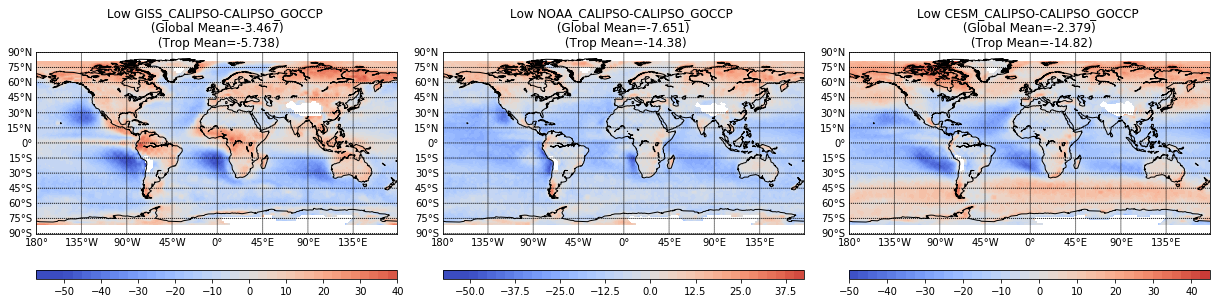

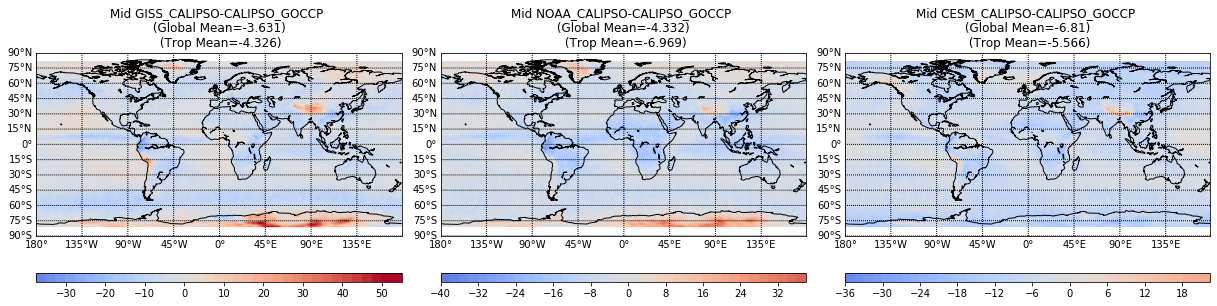

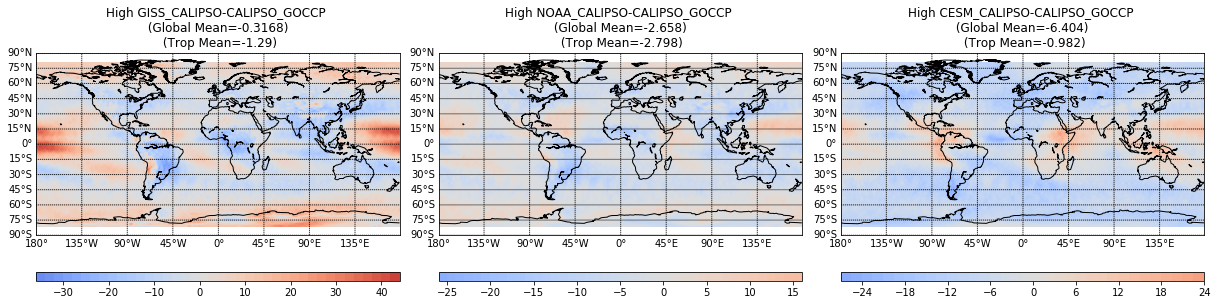

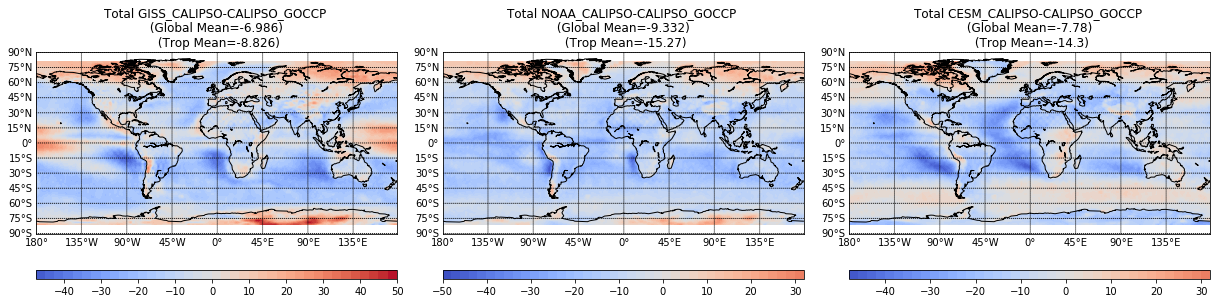

In [17]:
#Difference plot - Low CF
plt.figure(figsize=(17,13))
plt.subplot(131)
plot_2D_global(lons+180,lats,(np.roll(GCLLCALIPSO_interp,180,axis=1)-ocllcalipso_interp), data_name = 'Low GISS_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GCLLCALIPSO_interp,180,axis=1)-ocllcalipso_interp),np.mean(np.roll(GCLLCALIPSO_interp,180,axis=1)[60:121,:]-ocllcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
plt.subplot(132)
plot_2D_global(lons+180,lats,(np.roll(NCLLCALIPSO_interp,180,axis=1)-ocllcalipso_interp), data_name = 'Low NOAA_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NCLLCALIPSO_interp,180,axis=1)-ocllcalipso_interp),np.mean(np.roll(NCLLCALIPSO_interp,180,axis=1)[60:121,:]-ocllcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
plt.subplot(133)
plot_2D_global(lons+180,lats,(np.roll(CCLLCALIPSO_interp,180,axis=1)-ocllcalipso_interp), data_name = 'Low CESM_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CCLLCALIPSO_interp,180,axis=1)-ocllcalipso_interp),np.mean(np.roll(CCLLCALIPSO_interp,180,axis=1)[60:121,:]-ocllcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')

plt.tight_layout()
plt.savefig('Results/14LowCF_bias')
plt.show()

#Difference plot - Mid CF
plt.figure(figsize=(17,13))
plt.subplot(131)
plot_2D_global(lons+180,lats,(np.roll(GCLMCALIPSO_interp,180,axis=1)-oclmcalipso_interp), data_name = 'Mid GISS_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GCLMCALIPSO_interp,180,axis=1)-oclmcalipso_interp),np.mean(np.roll(GCLMCALIPSO_interp,180,axis=1)[60:121,:]-oclmcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
plt.subplot(132)
plot_2D_global(lons+180,lats,(np.roll(NCLMCALIPSO_interp,180,axis=1)-oclmcalipso_interp), data_name = 'Mid NOAA_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NCLMCALIPSO_interp,180,axis=1)-oclmcalipso_interp),np.mean(np.roll(NCLMCALIPSO_interp,180,axis=1)[60:121,:]-oclmcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
plt.subplot(133)
plot_2D_global(lons+180,lats,(np.roll(CCLMCALIPSO_interp,180,axis=1)-oclmcalipso_interp), data_name = 'Mid CESM_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CCLMCALIPSO_interp,180,axis=1)-oclmcalipso_interp),np.mean(np.roll(CCLMCALIPSO_interp,180,axis=1)[60:121,:]-oclmcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')

plt.tight_layout()
plt.savefig('Results/15MidCF_bias')
plt.show()

#Difference plot - High CF
plt.figure(figsize=(17,13))
plt.subplot(131)
plot_2D_global(lons+180,lats,(np.roll(GCLHCALIPSO_interp,180,axis=1)-oclhcalipso_interp), data_name = 'High GISS_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GCLHCALIPSO_interp,180,axis=1)-oclhcalipso_interp),np.mean(np.roll(GCLHCALIPSO_interp,180,axis=1)[60:121,:]-oclhcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
plt.subplot(132)
plot_2D_global(lons+180,lats,(np.roll(NCLHCALIPSO_interp,180,axis=1)-oclhcalipso_interp), data_name = 'High NOAA_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NCLHCALIPSO_interp,180,axis=1)-oclhcalipso_interp),np.mean(np.roll(NCLHCALIPSO_interp,180,axis=1)[60:121,:]-oclhcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
plt.subplot(133)
plot_2D_global(lons+180,lats,(np.roll(CCLHCALIPSO_interp,180,axis=1)-oclhcalipso_interp), data_name = 'High CESM_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CCLHCALIPSO_interp,180,axis=1)-oclhcalipso_interp),np.mean(np.roll(CCLHCALIPSO_interp,180,axis=1)[60:121,:]-oclhcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')

plt.tight_layout()
plt.savefig('Results/16HighCF_bias')
plt.show()

#Difference plot - Total CF
plt.figure(figsize=(17,13))
plt.subplot(131)
plot_2D_global(lons+180,lats,(np.roll(GCLTCALIPSO_interp,180,axis=1)-ocltcalipso_interp), data_name = 'Total GISS_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(GCLTCALIPSO_interp,180,axis=1)-ocltcalipso_interp),np.mean(np.roll(GCLTCALIPSO_interp,180,axis=1)[60:121,:]-ocltcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
plt.subplot(132)
plot_2D_global(lons+180,lats,(np.roll(NCLTCALIPSO_interp,180,axis=1)-ocltcalipso_interp), data_name = 'Total NOAA_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(NCLTCALIPSO_interp,180,axis=1)-ocltcalipso_interp),np.mean(np.roll(NCLTCALIPSO_interp,180,axis=1)[60:121,:]-ocltcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')
plt.subplot(133)
plot_2D_global(lons+180,lats,(np.roll(CCLTCALIPSO_interp,180,axis=1)-ocltcalipso_interp), data_name = 'Total CESM_CALIPSO-CALIPSO_GOCCP \n (Global Mean=%.4g) \n (Trop Mean=%.4g)' %(np.mean(np.roll(CCLTCALIPSO_interp,180,axis=1)-ocltcalipso_interp),np.mean(np.roll(CCLTCALIPSO_interp,180,axis=1)[60:121,:]-ocltcalipso_interp[60:121,:])), levels=40, plot_type='difference', vmin=-50, vmax=50, cmap='coolwarm')

plt.tight_layout()
plt.savefig('Results/13TotalCF_bias')
plt.show()


## Cloud Radiative Effect

In [18]:
tropical_C_CAL_CFLOW_interp = []
tropical_O_CAL_CFLOW_interp = []
tropical_C_CAL_CFMED_interp = []
tropical_O_CAL_CFMED_interp = []
tropical_C_CAL_CFHGH_interp = []
tropical_O_CAL_CFHGH_interp = []

def tropical(low_CF,mid_CF,high_CF,lat_i,lat_f,lon_i,lon_f,limmed,limhgh):
    new_low_CF = low_CF[lat_i:lat_f,lon_i:lon_f]
    new_mid_CF = mid_CF[lat_i:lat_f,lon_i:lon_f]
    new_high_CF = high_CF[lat_i:lat_f,lon_i:lon_f]
    regional_low_CF = np.zeros((len(new_low_CF),len(new_low_CF[0])))
    
    for i in range(len(new_low_CF)):
        for j in range(len(new_low_CF[0])):
            #if (new_mid_CF[i,j]<lim and new_high_CF[i,j]<lim or new_mid_CF[i,j]==None or new_high_CF[i,j]==None):
            if (new_mid_CF[i,j]>limmed and new_high_CF[i,j]>limhgh):
                #regional_low_CF[i,j] = new_low_CF[i,j]
                regional_low_CF[i,j] = None
            else:
                #regional_low_CF[i,j]=None
                regional_low_CF[i,j] = new_low_CF[i,j]
    return regional_low_CF

# Cloud radiative effect = Net cloudy - Net clear

def CRE(model,data_type,net_cloudy_sky,net_clear_sky,regional_lowcloud_interp,lat_i,lat_f,lon_i,lon_f):
    CRE = net_cloudy_sky-net_clear_sky
    roll_pt = 0
    CLLCALIPSO_data = CCLLCALIPSO_data    
    if data_type=='model':
        if model == 'cesm':
            CLLCALIPSO_data = CCLLCALIPSO_data
            roll_pt = 144
        elif model == 'noaa':
            CLLCALIPSO_data = NCLLCALIPSO_data
            roll_pt = 144
        elif model == 'giss':
            CLLCALIPSO_data = GCLLCALIPSO_data
            roll_pt = 72
        CRE_interp = basemap.interp(np.roll(CRE,roll_pt,axis=1),CLLCALIPSO_data.lons, CLLCALIPSO_data.lats, lonout, latout,checkbounds=False, masked=False, order=1)
    elif data_type=='obs':
        CRE_interp = CRE
    regional_CRE = CRE_interp[lat_i:lat_f,lon_i:lon_f]
    
    CF_bins = np.linspace(np.nanmin(regional_lowcloud_interp),np.nanmax(regional_lowcloud_interp),10)
    CRE_bins = np.zeros(len(CF_bins))
    
    for k in range(1,len(CF_bins)):
        m=0
        for i in range(len(regional_CRE)):
            for j in range(len(regional_CRE[0])):
                if CF_bins[k-1]<=regional_lowcloud_interp[i,j]<=CF_bins[k]:
                    m +=1
                    CRE_bins[k] += (regional_CRE[i,j])/m
                    
    return CF_bins,CRE_bins


#CRE when weighted by CF

def CRE_cfw(model, data_type,net_cloudy_sky,net_clear_sky,regional_lowcloud_interp,lat_i,lat_f,lon_i,lon_f):
    CRE = net_cloudy_sky-net_clear_sky
    roll_pt = 0
    CLLCALIPSO_data = CCLLCALIPSO_data
    if model == 'cesm':
        CLLCALIPSO_data = CCLLCALIPSO_data
        roll_pt = 144
    if model == 'noaa':
        CLLCALIPSO_data = NCLLCALIPSO_data
        roll_pt = 144
    if model == 'giss':
        CLLCALIPSO_data = GCLLCALIPSO_data
        roll_pt = 72   
    if data_type=='model':
        CRE_interp = basemap.interp(np.roll(CRE,roll_pt,axis=1),CLLCALIPSO_data.lons, CLLCALIPSO_data.lats, lonout, latout,checkbounds=False, masked=False, order=1)
    elif data_type=='obs':
        CRE_interp = CRE
    regional_CRE = CRE_interp[lat_i:lat_f,lon_i:lon_f]
    print (np.mean(np.mean(regional_CRE)))
    
    CF_bins = np.linspace(np.nanmin(regional_lowcloud_interp),np.nanmax(regional_lowcloud_interp),10)
    CRE_bins = np.zeros(len(CF_bins))
    m = np.zeros(len(CF_bins))
    
    for k in range(1,len(CF_bins)):
        for i in range(len(regional_CRE)):
            for j in range(len(regional_CRE[0])):
                if CF_bins[k-1]<=regional_lowcloud_interp[i,j]<=CF_bins[k]:
                    m[k] +=1
                    #CRE_bins[k] += (regional_CRE[i,j]*regional_lowcloud_interp[i,j])
                    CRE_bins[k] += (regional_CRE[i,j])
    
    return m,CF_bins,CRE_bins/m

### Minimum Values of Medium and High Level Clouds

In [19]:
#Observation_calipso
limmedm = print ('Obs',int(np.min((oclmcalipso_interp)[60:121,0:361])))
limhghm = print ('Obs',int(np.min((oclhcalipso_interp)[60:121,0:361])))

#GISS Model_calipso
limmed=print ('GISS',int(np.min(GCLMCALIPSO_interp[60:121,0:361])))
limhgh=print ('GISS',int(np.min(GCLHCALIPSO_interp[60:121,0:361])))

#NOAA Model_calipso
limmed=print ('NOAA',int(np.min(NCLMCALIPSO_interp[60:121,0:361])))
limhgh=print ('NOAA',int(np.min(NCLHCALIPSO_interp[60:121,0:361])))

#CESM Model_calipso
limmed=print ('CESM',int(np.min(CCLMCALIPSO_interp[60:121,0:361])))
limhgh=print ('CESM',int(np.min(CCLHCALIPSO_interp[60:121,0:361])))

Obs 0
Obs 5
GISS 0
GISS 4
NOAA 0
NOAA 4
CESM 0
CESM 2


In [20]:
#Low Cloud Fraction for Tropical Region

print ('cesm_trop_low=', np.nanmean(CCLLCALIPSO_interp[60:121,0:361]))
print ('giss_trop_low=', np.nanmean(GCLLCALIPSO_interp[60:121,0:361]))
print ('gfdl_trop_low=', np.nanmean(NCLLCALIPSO_interp[60:121,0:361]))
print ('obs_trop_low=', np.nanmean(ocllcalipso_interp[60:121,0:361]))

cesm_trop_low= 15.824959838659744
giss_trop_low= 24.92323977976123
gfdl_trop_low= 16.239417062772667
obs_trop_low= 30.618479803979366


### Picking/Saving non-overlapping Low Level Clouds

In [21]:
#Observation calipso
tropical_O_CAL_CFLOW_interp = tropical(ocllcalipso_interp,oclmcalipso_interp,oclhcalipso_interp,60,121,0,361,100,100)
#GISS model calipso
tropical_G_CAL_CFLOW_interp = tropical(GCLLCALIPSO_interp,GCLMCALIPSO_interp,GCLHCALIPSO_interp,60,121,0,361,100,100)
#NOAA model calipso
tropical_N_CAL_CFLOW_interp = tropical(NCLLCALIPSO_interp,NCLMCALIPSO_interp,NCLHCALIPSO_interp,60,121,0,361,100,100)
#CESM model calipso
tropical_C_CAL_CFLOW_interp = tropical(CCLLCALIPSO_interp,CCLMCALIPSO_interp,CCLHCALIPSO_interp,60,121,0,361,100,100)

np.save('giss_trop_new',tropical_G_CAL_CFLOW_interp)
np.save('cesm_trop_new',tropical_C_CAL_CFLOW_interp)
np.save('noaa_trop_new',tropical_N_CAL_CFLOW_interp)
np.save('calipso_trop_new',tropical_O_CAL_CFLOW_interp)

/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Warning: converting a masked element to nan.


### Picking/Saving Total Clouds

In [22]:
#Observation calipso
tropical_O_CAL_CFtot_interp = tropical(ocltcalipso_interp,oclmcalipso_interp,oclhcalipso_interp,60,121,0,361,100,100)
#GISS model calipso
tropical_G_CAL_CFtot_interp = tropical(GCLTCALIPSO_interp,GCLMCALIPSO_interp,GCLHCALIPSO_interp,60,121,0,361,100,100)
#NOAA model calipso
tropical_N_CAL_CFtot_interp = tropical(NCLTCALIPSO_interp,NCLMCALIPSO_interp,NCLHCALIPSO_interp,60,121,0,361,100,100)
#CESM model calipso
tropical_C_CAL_CFtot_interp = tropical(CCLTCALIPSO_interp,CCLMCALIPSO_interp,CCLHCALIPSO_interp,60,121,0,361,100,100)

np.save('giss_tropt_new',tropical_G_CAL_CFtot_interp)
np.save('cesm_tropt_new',tropical_C_CAL_CFtot_interp)
np.save('noaa_tropt_new',tropical_N_CAL_CFtot_interp)
np.save('calipso_tropt_new',tropical_O_CAL_CFtot_interp)

### Loading Non-overlapping Low Level Clouds

In [23]:
cesm_trop = np.load('cesm_trop_new.npy')
calipso_trop = np.load('calipso_trop_new.npy')
giss_trop = np.load('giss_trop_new.npy')
gfdl_trop = np.load('noaa_trop_new.npy')


print (np.shape(cesm_trop))
print (np.shape(calipso_trop))
print (np.shape(giss_trop))
print (np.shape(gfdl_trop))



print ('tropical low giss = ', np.nanmean(giss_trop))
print ('tropical low gfdl = ', np.nanmean(gfdl_trop))
print ('tropical low cesm = ', np.nanmean(cesm_trop))
print ('tropical low calipso = ', np.nanmean(calipso_trop))

(61, 360)
(61, 360)
(61, 360)
(61, 360)
tropical low giss =  24.92323977976123
tropical low gfdl =  16.239417062772667
tropical low cesm =  15.824959838659744
tropical low calipso =  30.618479803979366


### Loading trop total Clouds

In [24]:
cesm_tropt = np.load('cesm_tropt_new.npy')
calipso_tropt = np.load('calipso_tropt_new.npy')
giss_tropt = np.load('giss_tropt_new.npy')
gfdl_tropt = np.load('noaa_tropt_new.npy')


print (np.shape(cesm_tropt))
print (np.shape(calipso_tropt))
print (np.shape(giss_tropt))
print (np.shape(gfdl_tropt))



print ('tropical total giss = ', np.nanmean(giss_tropt))
print ('tropical total gfdl = ', np.nanmean(gfdl_tropt))
print ('tropical total cesm = ', np.nanmean(cesm_tropt))
print ('tropical total calipso = ', np.nanmean(calipso_tropt))

(61, 360)
(61, 360)
(61, 360)
(61, 360)
tropical total giss =  52.38757462888367
tropical total gfdl =  45.94159979714822
tropical total cesm =  46.91396576974612
tropical total calipso =  61.21335904033147


### Picking/Saving CRE of Non-overlapping Low Level Clouds

In [25]:
#tropical_CF_bins_gisscalipso,tropical_CRE_bins_gisscalipso = CRE('giss','model',giss_net_sw_data,giss_net_rscs_data,tropical_G_CAL_CFLOW_interp,60,121,0,361)
#tropical_CF_bins_noaacalipso,tropical_CRE_bins_noaacalipso = CRE('noaa','model',noaa_net_sw_data,noaa_net_rscs_data,tropical_N_CAL_CFLOW_interp,60,121,0,361)
#tropical_CF_bins_cesmcalipso,tropical_CRE_bins_cesmcalipso = CRE('cesm','model',cesm_net_sw_data,cesm_net_rscs_data,tropical_C_CAL_CFLOW_interp,60,121,0,361)
#tropical_CF_bins_obs,tropical_CRE_bins_obs = CRE('goccp','obs',net_sw_toa,net_sw_toa_clr,tropical_O_CAL_CFLOW_interp,60,121,0,361)


gissml,tropical_CF_bins_gisscalipsocfw,tropical_CRE_bins_gisscalipsocfw = CRE_cfw('giss','model',giss_net_sw_data,giss_net_rscs_data,tropical_G_CAL_CFLOW_interp,60,121,0,361)
noaaml,tropical_CF_bins_noaacalipsocfw,tropical_CRE_bins_noaacalipsocfw = CRE_cfw('noaa','model',noaa_net_sw_data,noaa_net_rscs_data,tropical_N_CAL_CFLOW_interp,60,121,0,361)
cesmml,tropical_CF_bins_cesmcalipsocfw,tropical_CRE_bins_cesmcalipsocfw = CRE_cfw('cesm','model',cesm_net_sw_data,cesm_net_rscs_data,tropical_C_CAL_CFLOW_interp,60,121,0,361)
obsml,tropical_CF_bins_obscfw,tropical_CRE_bins_obscfw = CRE_cfw('goccp','obs',net_sw_toa,net_sw_toa_clr,tropical_O_CAL_CFLOW_interp,60,121,0,361)

np.save('giss_bins_new',(gissml,tropical_CF_bins_gisscalipsocfw,tropical_CRE_bins_gisscalipsocfw))
np.save('cesm_bins_new',(cesmml,tropical_CF_bins_cesmcalipsocfw,tropical_CRE_bins_cesmcalipsocfw))
np.save('noaa_bins_new',(noaaml,tropical_CF_bins_noaacalipsocfw,tropical_CRE_bins_noaacalipsocfw))
np.save('calipso_bins_new',(obsml,tropical_CF_bins_obscfw,tropical_CRE_bins_obscfw))

-50.76848217177261
-46.58580227598383


/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide


-44.915654704497136
-43.021683


In [26]:
# Picking/Saving CRE of total clouds

tottropical_CF_bins_gisscalipso,tottropical_CRE_bins_gisscalipso = CRE('giss','model',giss_net_sw_data,giss_net_rscs_data,tropical_G_CAL_CFtot_interp,60,121,0,361)
tottropical_CF_bins_noaacalipso,tottropical_CRE_bins_noaacalipso = CRE('noaa','model',noaa_net_sw_data,noaa_net_rscs_data,tropical_N_CAL_CFtot_interp,60,121,0,361)
tottropical_CF_bins_cesmcalipso,tottropical_CRE_bins_cesmcalipso = CRE('cesm','model',cesm_net_sw_data,cesm_net_rscs_data,tropical_C_CAL_CFtot_interp,60,121,0,361)
tottropical_CF_bins_obs,tottropical_CRE_bins_obs = CRE('goccp','obs',net_sw_toa,net_sw_toa_clr,tropical_O_CAL_CFtot_interp,60,121,0,361)


gissm,tottropical_CF_bins_gisscalipsocfw,tottropical_CRE_bins_gisscalipsocfw = CRE_cfw('giss','model',giss_net_sw_data,giss_net_rscs_data,tropical_G_CAL_CFtot_interp,60,121,0,361)
noaam,tottropical_CF_bins_noaacalipsocfw,tottropical_CRE_bins_noaacalipsocfw = CRE_cfw('noaa','model',noaa_net_sw_data,noaa_net_rscs_data,tropical_N_CAL_CFtot_interp,60,121,0,361)
cesmm,tottropical_CF_bins_cesmcalipsocfw,tottropical_CRE_bins_cesmcalipsocfw = CRE_cfw('cesm','model',cesm_net_sw_data,cesm_net_rscs_data,tropical_C_CAL_CFtot_interp,60,121,0,361)
obsm,tottropical_CF_bins_obscfw,tottropical_CRE_bins_obscfw = CRE_cfw('goccp','obs',net_sw_toa,net_sw_toa_clr,tropical_O_CAL_CFtot_interp,60,121,0,361)

np.save('totgiss_bins_new',(gissm,tottropical_CF_bins_gisscalipsocfw,tottropical_CRE_bins_gisscalipsocfw))
np.save('totcesm_bins_new',(noaam,tottropical_CF_bins_cesmcalipsocfw,tottropical_CRE_bins_cesmcalipsocfw))
np.save('totnoaa_bins_new',(cesmm,tottropical_CF_bins_noaacalipsocfw,tottropical_CRE_bins_noaacalipsocfw))
np.save('totcalipso_bins_new',(obsm,tottropical_CF_bins_obscfw,tottropical_CRE_bins_obscfw))

-50.76848217177261
-46.58580227598383


/umbc/xfs1/zzbatmos/users/dwick1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide


-44.915654704497136
-43.021683


### Loading CRE of Non-overlapping Low Level Clouds

In [27]:

cesmml,cesmcf,cesmcre = np.load('cesm_bins_new.npy')
gissml,gisscf,gisscre = np.load('giss_bins_new.npy')
gfdlml,gfdlcf,gfdlcre = np.load('noaa_bins_new.npy')
calipsoml,calipsocf,calipsocre = np.load('calipso_bins_new.npy')


In [28]:
# Loading CRE of total CF

cesmm,totcesmcf,totcesmcre = np.load('totcesm_bins_new.npy')
gissm,totgisscf,totgisscre = np.load('totgiss_bins_new.npy')
gfdlm,totgfdlcf,totgfdlcre = np.load('totnoaa_bins_new.npy')
calipsom,totcalipsocf,totcalipsocre = np.load('totcalipso_bins_new.npy')

print (cesmm,totcesmcf,totcesmcre)
print (np.nanmean(cesmm*totcesmcre))

[   0.  741. 2067. 3148. 5332. 4985. 3654. 1625.  336.   72.] [ 6.98045748 16.75041752 26.52037756 36.2903376  46.06029765 55.83025769
 65.60021773 75.37017777 85.14013782 94.91009786] [         nan -38.40271658 -49.05548282 -45.49704558 -43.37208957
 -40.72597861 -41.18289769 -50.74738576 -62.7337396  -76.33235268]
-107431.00626519375


### Plotting Probability density function of non-overlapped low-cloud covers

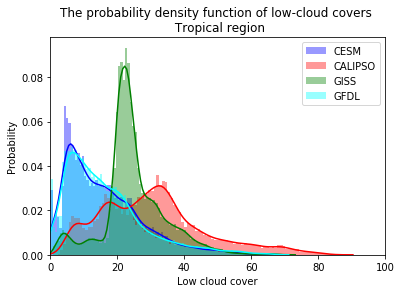

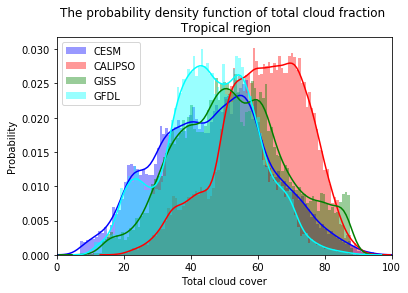

In [29]:
ax1 = sns.distplot(cesm_trop[~np.isnan(cesm_trop)], bins=100, color='blue',label="CESM")
ax2 = sns.distplot(calipso_trop[~np.isnan(calipso_trop)], bins=100, color='red',label="CALIPSO")
ax3 = sns.distplot(giss_trop[~np.isnan(giss_trop)], bins=100, color='green',label="GISS")
ax4 = sns.distplot(gfdl_trop[~np.isnan(gfdl_trop)], bins=100, color='cyan',label="GFDL")
#ax3 = sns.distplot(tropical_CLDLOW_interp[~np.isnan(tropical_CLDLOW_interp)], bins=100, color='green',label="CESM")
plt.legend()
#ax1.set_ylim(0,0.25)
ax1.set_xlim(0,100)
ax1.set(xlabel='Low cloud cover', ylabel='Probability')
plt.title('The probability density function of low-cloud covers \n Tropical region')
plt.savefig('Results/18Tropical_LowCF_pdf')
plt.show()

ax5 = sns.distplot(cesm_tropt[~np.isnan(cesm_tropt)], bins=100, color='blue',label="CESM")
ax6 = sns.distplot(calipso_tropt[~np.isnan(calipso_tropt)], bins=100, color='red',label="CALIPSO")
ax7 = sns.distplot(giss_tropt[~np.isnan(giss_tropt)], bins=100, color='green',label="GISS")
ax8 = sns.distplot(gfdl_tropt[~np.isnan(gfdl_tropt)], bins=100, color='cyan',label="GFDL")
#ax3 = sns.distplot(tropical_CLDLOW_interp[~np.isnan(tropical_CLDLOW_interp)], bins=100, color='green',label="CESM")
plt.legend()
#ax1.set_ylim(0,0.25)
ax5.set_xlim(0,100)
ax5.set(xlabel='Total cloud cover', ylabel='Probability')
plt.title('The probability density function of total cloud fraction \n Tropical region')
plt.savefig('pdf_tropical_region.png',dpi=200)
plt.savefig('Results/17Tropical_TotalCF_pdf')
plt.show()

### Plotting Shortwave cloud radiative effect variation with low cloud cover

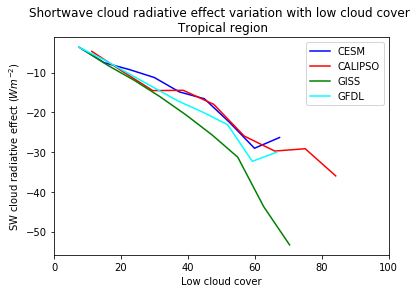

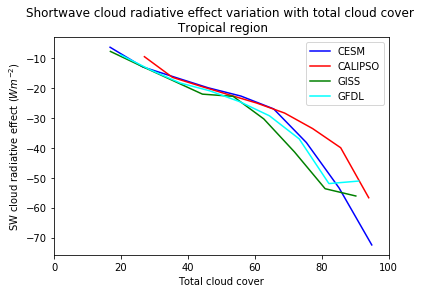

In [30]:
plt.plot(cesmcf,cesmcre*cesmcf/100,label='CESM',color='blue')
plt.plot(calipsocf,calipsocre*calipsocf/100,label='CALIPSO',color='red')
plt.plot(gisscf,gisscre*gisscf/100,label='GISS',color='green')
plt.plot(gfdlcf,gfdlcre*gfdlcf/100,label='GFDL',color='cyan')
plt.legend()
plt.title('Shortwave cloud radiative effect variation with low cloud cover \n Tropical region')
plt.xlabel('Low cloud cover')
plt.xlim(0,100)
plt.ylabel('SW cloud radiative effect ($Wm^{-2}$)')
plt.savefig('Results/20Tropical_LowCF_CRE')
plt.show()

plt.plot(totcesmcf,totcesmcre*totcesmcf/100,label='CESM',color='blue')
plt.plot(totcalipsocf,totcalipsocre*totcalipsocf/100,label='CALIPSO',color='red')
plt.plot(totgisscf,totgisscre*totgisscf/100,label='GISS',color='green')
plt.plot(totgfdlcf,totgfdlcre*totgfdlcf/100,label='GFDL',color='cyan')
plt.legend()
plt.title('Shortwave cloud radiative effect variation with total cloud cover \n Tropical region')
plt.xlabel('Total cloud cover')
plt.xlim(0,100)
plt.ylabel('SW cloud radiative effect ($Wm^{-2}$)')
plt.savefig('Results/19Tropical_TotalCF_CRE')
plt.show()